In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os, sys
import numpy as np

import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, utils
import mxnet.ndarray as F

from tqdm import tqdm

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
SOS_token = 0
EOS_token = 1

class Lang(object):
    def __init__(self):
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "  ", 1:"."}
        self.n_words = 2
        
    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)
            
    def addWord(self, word):
        for char in list(word):
            if char not in self.char2index:
                self.char2index[char] = self.n_words
                self.char2count[char] = 1
                self.index2char[self.n_words] = char
                self.n_words += 1
            else:
                self.char2count[char] += 1

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([\n!?])", r" ", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
def readLangs(file_nm):
    print("==Reading lines...==")
    ##read the txt files
    #lines = open('data/%s.txt' % (file_nm), encoding='utf-8').read().strip().split('\n')
    lines = open('data/%s.txt' % (file_nm), encoding='utf-8').read().strip()
    lines = lines.replace('Mr.','Mr')
    lines = lines.replace('Mrs.','Mrs')
    lines = lines.split('.')
    
    ##split eveline 
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    

    input_lang = Lang()
    
    return input_lang, pairs

In [5]:
MAX_LENGTH = 30

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH 


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(file_nm):
    input_lang, pairs = readLangs(file_nm)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(list(pair[0]))
    print("Counted words:")
    print(input_lang.n_words)
    
    pairs_by_char = list()
    
    return input_lang, pairs

In [7]:
input_lang, pairs = prepareData('pride_and_prejudice')

==Reading lines...==
Read 5052 sentence pairs
Trimmed to 3524 sentence pairs
Counting words...
Counted words:
50


In [34]:
input_lang.index2char

{0: '  ',
 1: '.',
 2: 'c',
 3: 'h',
 4: 'a',
 5: 'p',
 6: 't',
 7: 'e',
 8: 'r',
 9: ' ',
 10: '1',
 11: 'i',
 12: 's',
 13: 'u',
 14: 'n',
 15: 'v',
 16: 'l',
 17: 'y',
 18: 'k',
 19: 'o',
 20: 'w',
 21: 'd',
 22: 'g',
 23: ',',
 24: 'm',
 25: 'f',
 26: 'b',
 27: '“',
 28: '”',
 29: ';',
 30: 'j',
 31: '_',
 32: 'x',
 33: '-',
 34: 'z',
 35: '2',
 36: ':',
 37: "'",
 38: 'q',
 39: '5',
 40: '6',
 41: '8',
 42: '0',
 43: '7',
 44: '9',
 45: '4',
 46: '3',
 47: '(',
 48: ')',
 49: '*'}

In [8]:
input_lang.index2char.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [9]:
pairs_by_char = list()
for sentence in pairs:
    tmp = list()
    tmp.append("SOS")
    tmp.extend(list(sentence[0]))
    tmp.append(".")
    pairs_by_char.extend(tmp)

In [10]:
sentence = random.choice(pairs)
sentence

['elizabeth noticed every sentence conveying the idea of uneasiness, with an attention which it had hardly received on the first perusal']

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.char2index[word] for word in sentence]

In [12]:
data = list()
for sentence in pairs:
    a = [0]
    a.extend(indexesFromSentence(input_lang,list(sentence[0])))
    a.append(1)
    data.extend(a)

In [13]:
len(data)

291603

## Define hyperparameters

In [14]:
ctx = mx.gpu()

In [15]:
def data_generation(data,seq_size = 6000, mu=256,ctx=ctx):
    div = max(data.max(),abs(data.min()))
    #data = data/div
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start:start+seq_size]
        yield nd.array(ys[:seq_size],ctx=ctx)

In [16]:
class One_Hot(nn.Block):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        
    def forward(self, X_in):
        with X_in.context:
            X_in = X_in
            self.ones = nd.one_hot(nd.arange(self.depth),self.depth)
            return self.ones[X_in,:]

    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

In [17]:
class WaveNet(nn.Block):
    def __init__(self, mu=256,n_residue=32, n_skip= 512, dilation_depth=10, n_repeat=5):
        # mu: audio quantization size
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.dilation_depth = dilation_depth
        self.dilations = [2**i for i in range(dilation_depth)] * n_repeat      
        with self.name_scope():
            self.one_hot = One_Hot(mu)
            self.from_input = nn.Conv1D(in_channels=mu, channels=n_residue, kernel_size=1)
            self.conv_sigmoid = nn.Sequential()
            self.conv_tanh = nn.Sequential()
            self.skip_scale = nn.Sequential()
            self.residue_scale = nn.Sequential()
            for d in self.dilations:
                self.conv_sigmoid.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=2, dilation=d))
                self.conv_tanh.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=2, dilation=d))
                self.skip_scale.add(nn.Conv1D(in_channels=n_residue, channels=n_skip, kernel_size=1, dilation=d))
                self.residue_scale.add(nn.Conv1D(in_channels=n_residue, channels=n_residue, kernel_size=1, dilation=d))
            self.conv_post_1 = nn.Conv1D(in_channels=n_skip, channels=n_skip, kernel_size=1)
            self.conv_post_2 = nn.Conv1D(in_channels=n_skip, channels=mu, kernel_size=1)
        
    def forward(self,x):
        with x.context:
            output = self.preprocess(x)
            skip_connections = [] # save for generation purposes
            for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
                output, skip = self.residue_forward(output, s, t, skip_scale, residue_scale)
                skip_connections.append(skip)
            # sum up skip connections
            output = sum([s[:,:,-output.shape[2]:] for s in skip_connections])
            output = self.postprocess(output)
        return output
        
    def preprocess(self, x):
        output = F.transpose(self.one_hot(x).expand_dims(0),axes=(0,2,1))
        output = self.from_input(output)
        return output

    def postprocess(self, x):
        output = F.relu(x)
        output = self.conv_post_1(output)
        output = F.relu(output)
        output = self.conv_post_2(output)
        output = nd.reshape(output,(output.shape[1],output.shape[2]))
        output = F.transpose(output,axes=(1,0))
        return output
    
    def residue_forward(self, x, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = x
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = F.sigmoid(output_sigmoid) * F.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + x[:,:,-output.shape[2]:]
        return output, skip
        

## network training

This network tries to generate the vibrating sine wave above. 
- The audio signal is quantized to 64 discrete integers.
- 24 channels in residue outputs
- 128 channels in skip outputs
- 20 dilation layers (n_repeat=2, dilation_depth=10)

In [18]:
mu =len(input_lang.index2char.keys())
net = WaveNet(mu=mu,n_residue=24,n_skip=128,dilation_depth=10,n_repeat=2)
net.collect_params().initialize(ctx=ctx)
#set optimizer
trainer = gluon.Trainer(net.collect_params(),optimizer='adam',optimizer_params={'learning_rate':0.01 })
g = data_generation(np.array(data),mu=46, seq_size=8000,ctx=ctx)
batch_size = 64
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [19]:
loss_save = []
max_epoch = 500
best_loss = sys.maxsize
for epoch in range(max_epoch):
    loss = 0.0
    for _ in tqdm(range(batch_size)):
        batch = next(g)
        x = batch[:-1]
        with autograd.record():
            logits = net(x)
            sz = logits.shape[0]
            loss = loss + loss_fn(logits, batch[-sz:])
            #loss = loss/batch_size
        loss.backward()
        trainer.step(1,ignore_stale_grad=True)
    loss_save.append(nd.sum(loss).asscalar()/batch_size)
    #print('epoch {}, loss {}'.format(epoch, nd.sum(loss).asscalar()/batch_size))
    #save the best model
    current_loss = nd.sum(loss).asscalar()/batch_size
    if best_loss > current_loss:
        print('epoch {}, loss {}'.format(epoch, nd.sum(loss).asscalar()/batch_size))
        print("====save best model====")
        filename = './models/best_perf_models'
        net.save_parameters(filename)
        best_loss = current_loss
    


100%|██████████| 64/64 [00:02<00:00, 22.76it/s]
/home/ubuntu/anaconda3/lib/python3.6/site-packages/mxnet/gluon/block.py:338: UserWarning: save_params is deprecated. Please use save_parameters. Note that if you want to load from SymbolBlock later, please use export instead. For details, see https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html
  warnings.warn("save_params is deprecated. Please use save_parameters. "
  3%|▎         | 2/64 [00:00<00:03, 18.91it/s]

epoch 0, loss 16627.537109375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 22.73it/s]

epoch 1, loss 12889.400390625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 22.76it/s]

epoch 2, loss 10994.3583984375
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 19.05it/s]

epoch 3, loss 9709.263671875
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 18.68it/s]

epoch 4, loss 8951.544921875
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 18.81it/s]

epoch 5, loss 8384.20703125
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 18.51it/s]

epoch 6, loss 8118.6435546875
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.15it/s]

epoch 7, loss 7812.86669921875
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 24.98it/s]

epoch 8, loss 7683.63037109375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.11it/s]

epoch 9, loss 7454.4697265625
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 18.81it/s]

epoch 10, loss 7370.3359375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.42it/s]

epoch 11, loss 7255.8994140625
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 16.53it/s]

epoch 12, loss 7091.353515625
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 18.66it/s]

epoch 14, loss 7084.59912109375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 24.40it/s]

epoch 15, loss 6891.2861328125
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 24.82it/s]

epoch 16, loss 6882.048828125
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 24.04it/s]

epoch 18, loss 6775.12939453125
====save best model====


  5%|▍         | 3/64 [00:00<00:03, 19.01it/s]

epoch 19, loss 6652.673828125
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 24.91it/s]

epoch 21, loss 6566.8955078125
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.50it/s]

epoch 22, loss 6559.25
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.51it/s]

epoch 23, loss 6523.1650390625
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 16.83it/s]

epoch 26, loss 6475.7744140625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.11it/s]

epoch 27, loss 6417.6025390625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 24.78it/s]

epoch 28, loss 6367.4384765625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.21it/s]

epoch 29, loss 6363.3427734375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.32it/s]

epoch 31, loss 6341.9609375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.40it/s]

epoch 32, loss 6228.4443359375
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 18.48it/s]

epoch 38, loss 6205.787109375
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 18.84it/s]

epoch 39, loss 6120.8671875
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 19.11it/s]

epoch 41, loss 6015.0478515625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.28it/s]

epoch 48, loss 5943.9697265625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.53it/s]

epoch 50, loss 5885.3544921875
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 19.26it/s]

epoch 53, loss 5815.5166015625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 24.78it/s]

epoch 62, loss 5775.6240234375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 24.99it/s]

epoch 67, loss 5755.419921875
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.84it/s]

epoch 71, loss 5657.56201171875
====save best model====


  5%|▍         | 3/64 [00:00<00:03, 19.96it/s]

epoch 84, loss 5633.201171875
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.93it/s]

epoch 89, loss 5629.2060546875
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.85it/s]

epoch 90, loss 5577.755859375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 23.52it/s]

epoch 93, loss 5553.68505859375
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 19.13it/s]

epoch 101, loss 5449.234375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.49it/s]

epoch 135, loss 5431.78955078125
====save best model====


  3%|▎         | 2/64 [00:00<00:03, 19.83it/s]

epoch 139, loss 5415.6943359375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 23.29it/s]

epoch 152, loss 5396.6640625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.53it/s]

epoch 163, loss 5362.822265625
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.08it/s]

epoch 171, loss 5301.751953125
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.58it/s]

epoch 200, loss 5266.51904296875
====save best model====


  5%|▍         | 3/64 [00:00<00:03, 20.13it/s]

epoch 205, loss 5232.380859375
====save best model====


  5%|▍         | 3/64 [00:00<00:02, 25.85it/s]

epoch 279, loss 5224.14013671875
====save best model====


100%|██████████| 64/64 [00:02<00:00, 22.50it/s]


100%|██████████| 64/64 [00:02<00:00, 22.01it/s]


In [36]:
##save loss func
np.savez('loss_save.npz',np.array(loss_save))

In [21]:
os.getcwd()

'/home/skinet/work/research/WaveNet'

In [21]:
##load best network
net.load_params('./models/best_perf_models')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/mxnet/gluon/block.py:413: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


In [40]:
g_gen = data_generation(np.array(data),mu=46, seq_size=10000,ctx=ctx)

In [42]:
seed = next(g_gen)

In [43]:
def generate_slow(x,models,dilation_depth,n_repeat,ctx, n=100):
    dilations = [2**i for i in range(dilation_depth)] * n_repeat 
    res = list(x.asnumpy())
    for _ in tqdm(range(n)):
        x = nd.array(res[-sum(dilations)-1:],ctx=ctx)
        y = models(x)
        res.append(y.argmax(1).asnumpy()[-1])
    return res

In [45]:
gen_text= generate_slow(seed,net,dilation_depth=10,n_repeat=2,ctx=mx.gpu(),n=5000)

100%|██████████| 5000/5000 [01:19<00:00, 63.29it/s]


In [46]:
gen_sentence = ''
for idx in gen_text[9900:]:
    gen_sentence +=input_lang.index2char[idx]

In [47]:
gen_sentence

"o others as in his reproaches to myself.  after this period every appearance of acquaintance was dropped afraiding his silly had was alday with him asking--and should be this is no loveloof, and not to talk what is a very connocte was to be so i do not see her her friend.  he had better to be so elizabeth had been at not to her at a more that i had heard house thought the will be an endual to the saw her heart, and then to be so well.  ”  this indefully.  ”  “i shall not to ste't thought had all her afraid of some to smility, there is a conduct of he has been at liked a great probably and a letter of shall be in to be imagined to her thanking the former of her had been the same not very store well, and of a short the whole poor half as little a shall not her sister any horrive to stay--i so few hhar_ a visits.  it is convinced that course to her.  ”  “that is a readily, however, i should be of it would be so welcome was rain.  strue.  i am her defleaty.  her invalians.  ”  “but if i a

In [37]:
a = np.array(loss_save)

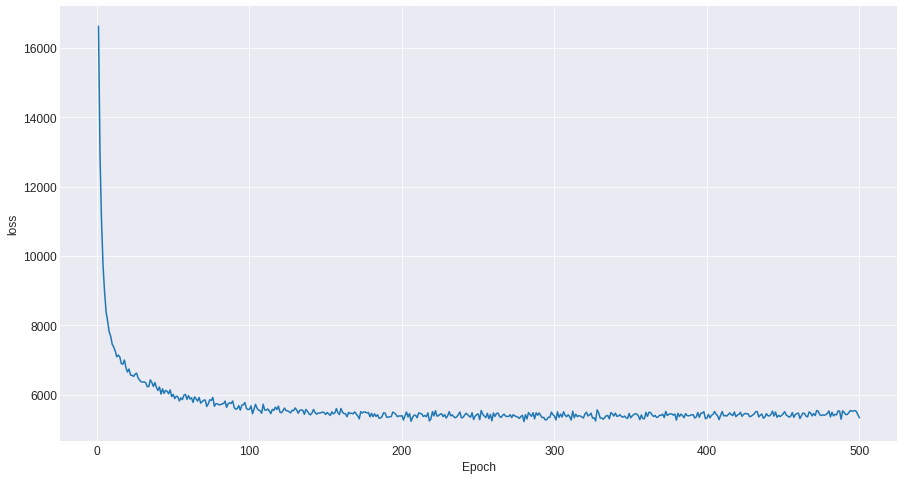

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,8))
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.plot(np.arange(500)+1,  a,label="loss")
plt.show()